# Analysis

In [30]:
model_at_title = r"$\bf{{{x}}}$".format(x="Claude\ 3.5\ Haiku")

In [1]:
import pandas as pd
from pathlib import Path
result_path = Path("../results")
answers_df = pd.read_csv(result_path / "results_self_play_claude-3.5-haiku.csv")
answers_df.head()

,scenario_id,record_id,level,correct_debater_pos,label,baseline,judge,chosen_debater,a_quote_acc,a_quote_num,b_quote_acc,b_quote_num,chosen_debater_quote_acc_diff,Baseline Correct,Judge Correct
0,524987bd2b554b2f909ba71339258d7b,9893e7f7-71d8-429e-9c50-12b30ce18200,LowConflict,1,proved,unknown,disproved,2,0.500000,10,0.833333,12,0.333333,0,0
1,524987bd2b554b2f909ba71339258d7b,6019d0e5-83ff-4bc3-a012-fb724ba15a4c,LowConflict,2,proved,unknown,disproved,1,1.000000,7,1.000000,7,0.000000,0,0
2,524987bd2b554b2f909ba71339258d7b,608c69ca-981c-43b8-b630-6e4903a0943b,LowConflict,-1,proved,unknown,disproved,1,0.857143,7,1.000000,7,-0.142857,0,0
3,0f72d2ac8542323babccd7fdb6584841,ec49fd55-3d79-4a5c-80e5-5c08f03a1785,LowConflict,1,proved,proved,proved,1,0.875000,8,1.000000,3,-0.125000,1,1
4,0f72d2ac8542323babccd7fdb6584841,bf0c225c-41bf-43bc-b8ba-10ce944c5675,LowConflict,2,proved,proved,proved,2,1.000000,5,1.000000,6,0.000000,1,1


In [2]:
import seaborn as sns
from matplotlib import pyplot as plt

sns.set_theme(style="whitegrid", palette="colorblind")

## Fundamental Effectiveness

### Does the debate process improve accuracy compared to baseline direct answers?

In [3]:
# Calculate accuracy
baseline_correct = answers_df["Baseline Correct"].sum()
judge_correct = answers_df["Judge Correct"].sum()
total = len(answers_df)

baseline_accuracy = baseline_correct / total
judge_accuracy = judge_correct / total

print(f"Baseline Accuracy: {baseline_accuracy:.2%}")
print(f"Judge Accuracy: {judge_accuracy:.2%}")

if baseline_accuracy > judge_accuracy:
    print("Baseline is better")
else:
    print("Judge is better")


Baseline Accuracy: 45.83%
Judge Accuracy: 39.44%
Baseline is better


In [4]:
import pandas as pd
from statsmodels.stats.contingency_tables import mcnemar


def test_debate_effectiveness(answers_df):
    # Create contingency table for McNemar's test
    # Both correct (1,1), baseline wrong & judge right (0,1),
    # baseline right & judge wrong (1,0), both wrong (0,0)
    contingency = pd.crosstab(
        answers_df["baseline"] == answers_df["label"],
        answers_df["judge"] == answers_df["label"],
    )
    r = mcnemar(contingency)
    odds_ratio = contingency.iloc[1, 0] / contingency.iloc[0, 1]

    print("McNemar's Test Results:")
    print(f"Statistic: {r.statistic:.3f}")
    print(f"P-value: {r.pvalue:.3f}")
    print(f"Odds ratio: {odds_ratio:.3f}")

    return r.statistic, r.pvalue, odds_ratio


stat, p_val, ratio = test_debate_effectiveness(answers_df)
print(f"Statistic: {stat:.3f}")
print(f"P-value: {p_val:.3f}")
print(f"Odds ratio: {ratio:.3f}")
if p_val < 0.05:
    print("Reject null hypothesis: Baseline and judge have different effectiveness")
else:
    print(
        "Fail to reject null hypothesis: Baseline and judge have similar effectiveness"
    )


McNemar's Test Results:
Statistic: 66.000
P-value: 0.077
Odds ratio: 1.348
Statistic: 66.000
P-value: 0.077
Odds ratio: 1.348
Fail to reject null hypothesis: Baseline and judge have similar effectiveness


Hmm.. that's actually weird.

Remember our debate setup:
1. 1st speaking debater arguing for the correct answer
2. 2nd speaking debater arguing for the correct answer
3. No debater arguing for the correct answer

We call the 3rd setup 'incorrect debate setup'. 

### What is the effect of having an incorrect debate setup?

In [5]:
incorrect_debate_df = answers_df[answers_df["correct_debater_pos"] == -1]
incorrect_debs_results = incorrect_debate_df.groupby("level").agg(
    Count=("level", "count"),
    Baseline=("Baseline Correct", "mean"),
    Judge=("Judge Correct", "mean"),
)
incorrect_debs_results["Accuracy Gain"] = (
    incorrect_debs_results["Judge"] - incorrect_debs_results["Baseline"]
)
incorrect_debs_results

,Count,Baseline,Judge,Accuracy Gain
level,,,,
HighConflict,60,0.383333,0.0,-0.383333
LowConflict,60,0.533333,0.0,-0.533333


This setup definitely skew the overal results!

In [6]:
# Remove Position -1
correct_exist_df = answers_df[answers_df["correct_debater_pos"] != -1]
correct_exist_results = correct_exist_df.groupby("level", as_index=False).agg(
    Count=("level", "count"),
    Baseline=("Baseline Correct", "mean"),
    Judge=("Judge Correct", "mean"),
)
correct_exist_results["Accuracy Gain"] = (
    correct_exist_results["Judge"] - correct_exist_results["Baseline"]
)
print("\nAccuracy by level (excluding 'No Correct Debater' setup):")
correct_exist_results


Accuracy by level (excluding 'No Correct Debater' setup):


,level,Count,Baseline,Judge,Accuracy Gain
0,HighConflict,120,0.383333,0.575000,0.191667
1,LowConflict,120,0.533333,0.608333,0.075000


In [40]:
print(correct_exist_results.to_string(index=False))

       level  Count  Baseline    Judge  Accuracy Gain
HighConflict    120  0.383333 0.575000       0.191667
 LowConflict    120  0.533333 0.608333       0.075000


C:\Users\Hp\AppData\Local\Temp\ipykernel_3528\3072179422.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  incorrect_debate_df["Setup Coverage"] = "'No Correct Debater' Only"


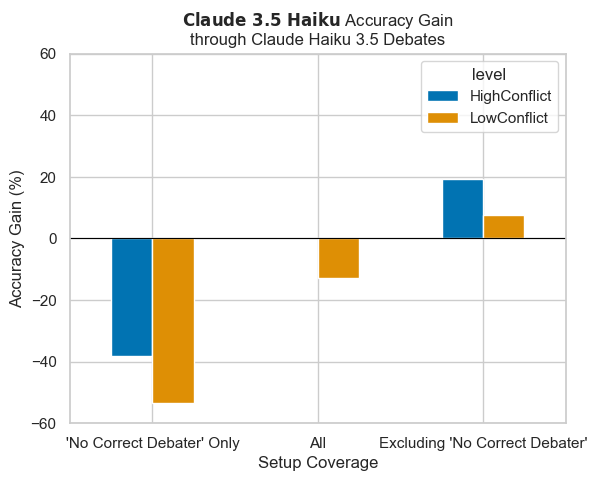

In [31]:
# Join the two dataframes then plot
answers_df_ = answers_df.copy()
answers_df_["Setup Coverage"] = "All"
correct_exist_df_ = correct_exist_df.copy()
correct_exist_df_["Setup Coverage"] = "Excluding 'No Correct Debater'"
incorrect_debate_df["Setup Coverage"] = "'No Correct Debater' Only"
merged_answers_df = pd.concat([correct_exist_df_, answers_df_, incorrect_debate_df])
# Plot the baseline and judge accuracy by level while comparing between protocol (hue)
merged_results = merged_answers_df.groupby(
    ["Setup Coverage", "level"], as_index=False
).agg(
    Baseline=("Baseline Correct", "mean"),
    Judge=("Judge Correct", "mean"),
)
merged_results["Accuracy Gain"] = (merged_results["Judge"] - merged_results["Baseline"]) * 100

# Plot the accuracy gain
merged_results.pivot(
    index="Setup Coverage", columns="level", values="Accuracy Gain"
).plot(
    kind="bar",
    title=model_at_title + " Accuracy Gain\nthrough Claude Haiku 3.5 Debates",
    ylim=(-60, 60),
    ylabel="Accuracy Gain (%)",
    rot=0,
)
plt.axhline(0, color="black", linewidth=0.8)
plt.show()


Looking at the full setup (including "No Correct Debater"):
- High Conflict: NO improvement from baseline (0.383 → 0.383, gain = 0)
- Low Conflict: Actually WORSE than baseline (0.533 → 0.406, loss of 0.128)

But when we exclude "No Correct Debater" cases:
- High Conflict: Substantial IMPROVEMENT (0.383 → 0.575, gain of 0.192)
- Low Conflict: Modest improvement (0.533 → 0.608, gain of 0.075)

This is quite revealing! Including the "No Correct Debater" setup is actually masking the real effectiveness of the debate process. When we focus only on cases where at least one debater has the correct answer, the debate system shows clear improvements over baseline, especially in high conflict scenarios.

Particularly striking is the high conflict case - the debate process appears to be most valuable precisely when there are conflicting rules or information, showing a substantial 19.2 percentage point improvement. This suggests the debate format is doing what we want it to do: helping clarify complex, conflicting situations.

For the rest of the analysis, we should definitely exclude the "No Correct Debater" setup. Including it:
1. Masks the true effectiveness of the debate process
2. Artificially deflates performance metrics
3. Doesn't represent the intended use case (in real applications, we'd want at least one debater to have access to the truth)

While the "No Correct Debater" setup was an interesting experimental condition, it's served its purpose in showing that the judge consistently fails when neither debater has the truth (as we'd hope). For understanding and improving the debate system's effectiveness, we should focus on the cases where truth is available to at least one debater.

Let's do the statistical test again!

In [8]:
stat, p_val, ratio = test_debate_effectiveness(correct_exist_df)
print(f"Statistic: {stat:.3f}")
print(f"P-value: {p_val:.3f}")
print(f"Odds ratio: {ratio:.3f}")
if p_val < 0.05:
    print("Reject null hypothesis: Baseline and judge have different effectiveness")
else:
    print(
        "Fail to reject null hypothesis: Baseline and judge have similar effectiveness"
    )


McNemar's Test Results:
Statistic: 34.000
P-value: 0.002
Odds ratio: 0.515
Statistic: 34.000
P-value: 0.002
Odds ratio: 0.515
Reject null hypothesis: Baseline and judge have different effectiveness


### How does performance vary across different levels of information conflict?


Accuracy by level:
       level  Count  Baseline     Judge
HighConflict    120 38.333333 57.500000
 LowConflict    120 53.333333 60.833333


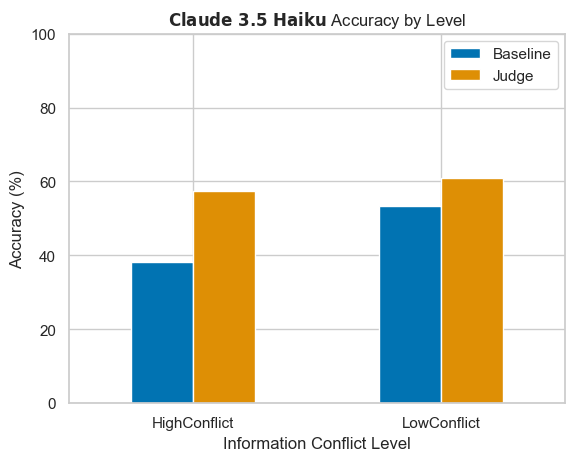

In [32]:
# Break down by level
level_results = correct_exist_df.groupby("level", as_index=False).agg(
    Count=("level", "count"),
    Baseline=("Baseline Correct", lambda x: x.mean()*100),
    Judge=("Judge Correct", lambda x: x.mean()*100),
)
# level_results["Accuracy Gain"] = level_results["Judge"] - level_results["Baseline"]

print("\nAccuracy by level:")
print(level_results.to_string(index=False))

level_results.plot(
    y=["Baseline", "Judge"],
    x="level",
    kind="bar",
    title=model_at_title + " Accuracy by Level",
    rot=0,
    ylim=(0, 100),
    ylabel="Accuracy (%)",
    xlabel="Information Conflict Level"
)
plt.show()

## Structural Biases

### Is there a systematic advantage to arguing first or second in the debate?

[]

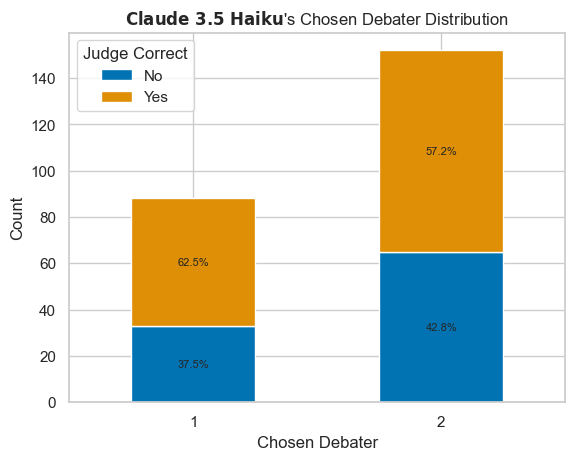

In [34]:
chosen_debater_counts = correct_exist_df.copy()
chosen_debater_counts["Judge Correct"] = chosen_debater_counts["Judge Correct"].map(
    {1: "Yes", 0: "No"}
)
x = chosen_debater_counts.groupby(["chosen_debater", "Judge Correct"])
chosen_debater_counts = x.size().unstack()
chosen_debater_counts.plot(
    kind="bar",
    title=model_at_title + "'s Chosen Debater Distribution",
    rot=0,
    ylabel="Count",
    xlabel="Chosen Debater",
    stacked=True,
)
# Add percentage labels

label = []
for i in range(2):
    for j in range(2):
        label.append(chosen_debater_counts.iloc[j, i] / chosen_debater_counts.iloc[j].sum())
i = 0
for p in plt.gca().patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    plt.gca().annotate(
        f"{label[i]*100:.1f}%",
        (x + width / 2, y + height / 2),
        ha="center",
        va="center",
        fontsize=8,
    )
    i += 1
plt.plot()


Overall position distribution:
 chosen_debater  correct_debater_pos Judge Correct  Count  Percentage
              1                    1       Correct     55    0.229167
              1                    2     Incorrect     33    0.137500
              2                    1     Incorrect     65    0.270833
              2                    2       Correct     87    0.362500


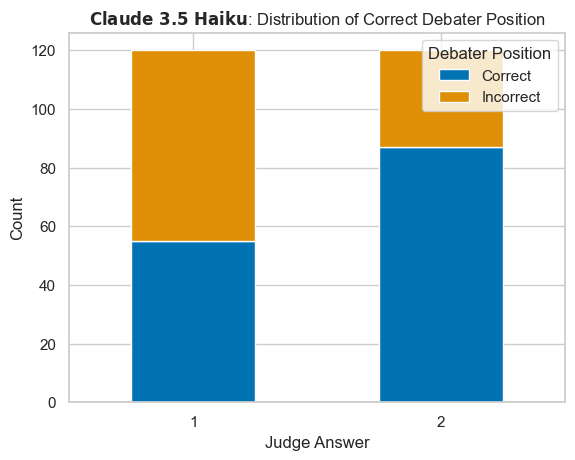

In [35]:
# Calculate overall position bias
position_counts = correct_exist_df.groupby(
    ["chosen_debater", "correct_debater_pos", "Judge Correct"], as_index=False
).agg(Count=("correct_debater_pos", "count"))
position_counts["Percentage"] = position_counts["Count"] / len(correct_exist_df)
position_counts["Judge Correct"] = position_counts["Judge Correct"].map(
    {0: "Incorrect", 1: "Correct"}
)

print("\nOverall position distribution:")
print(position_counts.to_string(index=False))

position_counts.pivot(
    index="correct_debater_pos", columns="Judge Correct", values="Count"
).plot(
    kind="bar",
    # figsize=(10, 6),
    title=model_at_title + ": Distribution of Correct Debater Position",
    rot=0,
    ylabel="Count",
    xlabel="Judge Answer",
    stacked=True,
)
plt.legend(title="Debater Position")
plt.show()


Accuracy by correct debater position:
 correct_debater_pos  Count  Baseline    Judge  Accuracy Gain
                   1    120  0.458333 0.458333       0.000000
                   2    120  0.458333 0.725000       0.266667


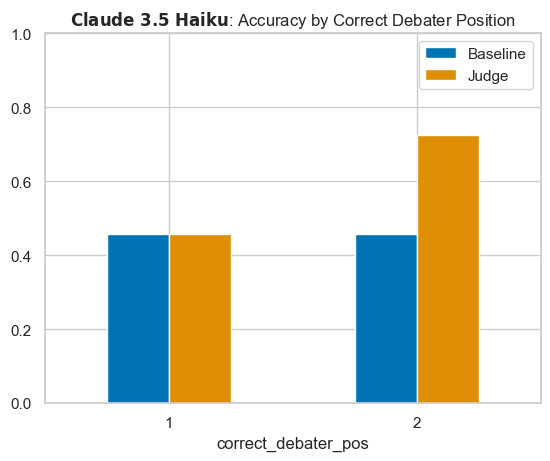

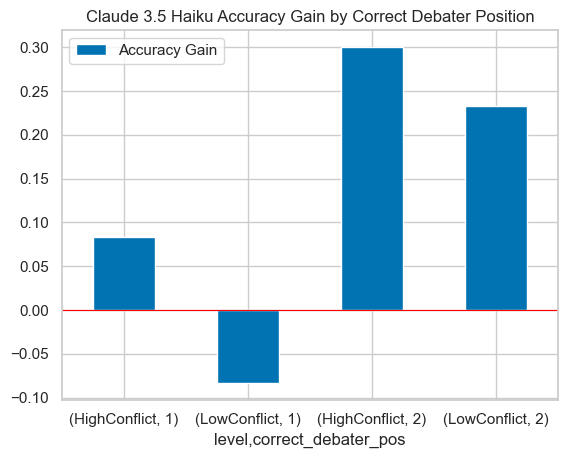

In [36]:
# Break down by correct debater position and accuracy gain based on the baseline
correct_debater_results = correct_exist_df.groupby(
    ["correct_debater_pos"], as_index=False
).agg(
    Count=("correct_debater_pos", "count"),
    Baseline=("Baseline Correct", "mean"),
    Judge=("Judge Correct", "mean"),
)
correct_debater_results["Accuracy Gain"] = (
    correct_debater_results["Judge"] - correct_debater_results["Baseline"]
)

print("\nAccuracy by correct debater position:")
print(correct_debater_results.to_string(index=False))

correct_debater_results.plot(
    x="correct_debater_pos",
    y=["Baseline", "Judge"],
    kind="bar",
    title=model_at_title + ": Accuracy by Correct Debater Position",
    rot=0,
)
plt.ylim(0, 1)
plt.show()

# Plot again but comparing between level
correct_debater_results_ = correct_exist_df.groupby(
    ["correct_debater_pos", "level"], as_index=False
).agg(
    Count=("correct_debater_pos", "count"),
    Baseline=("Baseline Correct", "mean"),
    Judge=("Judge Correct", "mean"),
)
correct_debater_results_["Accuracy Gain"] = (
    correct_debater_results_["Judge"] - correct_debater_results_["Baseline"]
)
correct_debater_results_.set_index(
    [
        "level",
        "correct_debater_pos",
    ]
).plot(
    # x="correct_debater_pos",
    y="Accuracy Gain",
    kind="bar",
    title="Claude 3.5 Haiku Accuracy Gain by Correct Debater Position",
    rot=0,
)
plt.axhline(0, color="red", linewidth=0.8)
plt.show()

#### Testing for position bias

In [13]:
alpha = 0.05
print(f"\nSignificance level: {alpha}")

for level in answers_df["level"].unique():
    level_data = answers_df[answers_df["level"] == level]

    # Create contingency table for debater position vs judge accuracy
    contingency = pd.crosstab(
        level_data["correct_debater_pos"], level_data["judge"] == level_data["label"]
    )

    # Perform chi-square test
    chi2, p_value = stats.chi2_contingency(contingency)[:2]

    print(f"\n===== {level} =====")
    print("Contingency table:")
    print(contingency)
    print(f"Chi-square statistic: {chi2:.2f}")
    print(f"p-value: {p_value}")
    if p_value < alpha:
        print(
            "Reject null hypothesis: debater position is associated with judge accuracy"
        )
    else:
        print(
            "Fail to reject null hypothesis: debater position is not associated with judge accuracy"
        )

    # Calculate the effect size
    n = contingency.sum().sum()
    phi = np.sqrt(chi2 / n)
    print(
        f"Effect size: {phi:.2f} ({'Small' if phi < 0.1 else 'Medium' if phi < 0.3 else 'Large'})"
    )


Significance level: 0.05


NameError: name 'stats' is not defined

### Do certain types of claims (proved/disproved/unknown) have systematically different success rates?


Accuracy by level and label:
       level     label  Count  Baseline    Judge  Accuracy Gain
HighConflict disproved     60      0.20 0.466667       0.266667
HighConflict    proved     60      0.35 0.266667      -0.083333
HighConflict   unknown     60      0.60 0.416667      -0.183333
 LowConflict disproved     60      0.25 0.466667       0.216667
 LowConflict    proved     60      0.70 0.333333      -0.366667
 LowConflict   unknown     60      0.65 0.416667      -0.233333


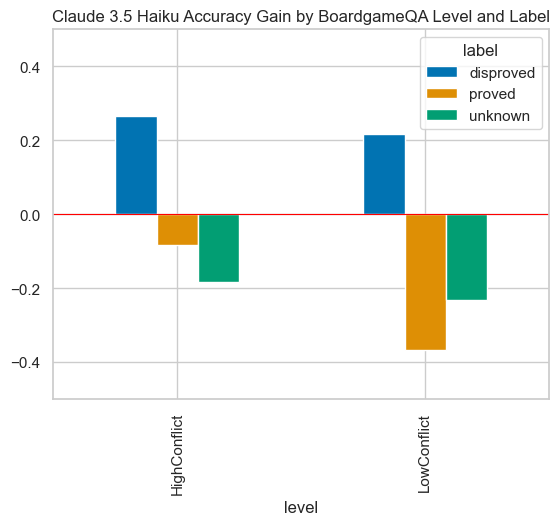

In [15]:
# Break down by level and label
level_label_results = answers_df.groupby(["level", "label"], as_index=False).agg(
    Count=("level", "count"),
    Baseline=("baseline", lambda x: (x == answers_df.loc[x.index, "label"]).mean()),
    Judge=("judge", lambda x: (x == answers_df.loc[x.index, "label"]).mean()),
)
level_label_results["Accuracy Gain"] = (
    level_label_results["Judge"] - level_label_results["Baseline"]
)

print("\nAccuracy by level and label:")
print(level_label_results.to_string(index=False))

level_label_results.pivot(index="level", columns="label", values="Accuracy Gain").plot(
    kind="bar",
    title="Claude 3.5 Haiku Accuracy Gain by BoardgameQA Level and Label",
    ylim=(-0.5, 0.5),
)
# Add a horizontal line at 0
plt.axhline(0, color="red", linewidth=0.8)
plt.show()

#### Testing for label bias

In [162]:
# # Do certain types of claims (proved/disproved/unknown) have systematically different success rates?
# # Perform statistical test to compare the accuracy of different labels
# alpha = 0.05
# print(f"\nSignificance level: {alpha}")

# for level in answers_df["level"].unique():


### Does the conflict level of scenarios affect judge accuracy independently of other factors?

In [163]:
# Does the conflict level of scenarios affect judge accuracy independently of other factors?


## Evidence Usage

### Does using more verified quotes lead to higher success rates in debates?

- Is the judge better at selecting debaters who use evidence more accurately?
- Does the relationship between quote accuracy and judge performance vary by conflict level?

All: Judge accuracy when its selected debater give:
 - more correct quotes than other: 37.80%
 - equal correct quotes as other : 40.56%
 - otherwise                     : 39.62%
Judge is not more likely to be correct when its selected debater gives more correct quotes
t-statistic: 0.582
p-value: 0.561
Fail to reject null hypothesis: accuracy difference is not significant

LowConflict: Judge accuracy when its selected debater gave:
 - more correct quotes than other: 44.44%
 - equal correct quotes as other : 38.83%
 - otherwise                     : 39.13%
t-statistic: 1.811
p-value: 0.072
Fail to reject null hypothesis: accuracy difference is not significant

HighConflict: Judge accuracy when its selected debater gave:
 - more correct quotes than other: 32.88%
 - equal correct quotes as other : 42.86%
 - otherwise                     : 40.00%
t-statistic: -0.860
p-value: 0.391
Fail to reject null hypothesis: accuracy difference is not significant


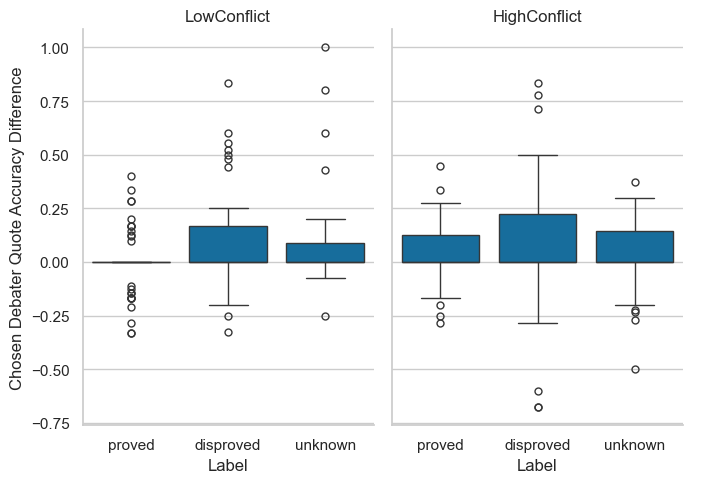

In [175]:
from scipy import stats

# Calculate average accuracy for positive and negative chosen_debater_quote_acc_diff
pos_acc = (
    answers_df[answers_df["chosen_debater_quote_acc_diff"] > 0]["judge"]
    == answers_df[answers_df["chosen_debater_quote_acc_diff"] > 0]["label"]
)
eq_acc = (
    answers_df[answers_df["chosen_debater_quote_acc_diff"] == 0]["judge"]
    == answers_df[answers_df["chosen_debater_quote_acc_diff"] == 0]["label"]
)
neg_acc = (
    answers_df[answers_df["chosen_debater_quote_acc_diff"] < 0]["judge"]
    == answers_df[answers_df["chosen_debater_quote_acc_diff"] < 0]["label"]
)

print("All: Judge accuracy when its selected debater give:")
print(f" - more correct quotes than other: {pos_acc.mean():.2%}")
print(f" - equal correct quotes as other : {eq_acc.mean():.2%}")
print(f" - otherwise                     : {neg_acc.mean():.2%}")

if pos_acc.mean() > neg_acc.mean():
    print(
        "Judge is more likely to be correct when its selected debater gives more correct quotes"
    )
else:
    print(
        "Judge is not more likely to be correct when its selected debater gives more correct quotes"
    )

# Perform t-test between chosen_debater_quote_acc_diff for correct vs incorrect judgements
correct_diffs = answers_df[answers_df["judge"] == answers_df["label"]][
    "chosen_debater_quote_acc_diff"
]
incorrect_diffs = answers_df[answers_df["judge"] != answers_df["label"]][
    "chosen_debater_quote_acc_diff"
]
t_stat, p_value = stats.ttest_ind(correct_diffs, incorrect_diffs)

print(f"t-statistic: {t_stat:.3f}")
print(f"p-value: {p_value:.3f}")
if p_value < alpha:
    print("Reject null hypothesis: accuracy difference is significant")
else:
    print("Fail to reject null hypothesis: accuracy difference is not significant")

# Calculate and print statistics by level
for level in answers_df["level"].unique():
    level_data = answers_df[answers_df["level"] == level]
    pos_acc = (
        level_data[level_data["chosen_debater_quote_acc_diff"] > 0]["judge"]
        == level_data[level_data["chosen_debater_quote_acc_diff"] > 0]["label"]
    )
    eq_acc = (
        level_data[level_data["chosen_debater_quote_acc_diff"] == 0]["judge"]
        == level_data[level_data["chosen_debater_quote_acc_diff"] == 0]["label"]
    )
    neg_acc = (
        level_data[level_data["chosen_debater_quote_acc_diff"] < 0]["judge"]
        == level_data[level_data["chosen_debater_quote_acc_diff"] < 0]["label"]
    )

    print(f"\n{level}: Judge accuracy when its selected debater gave:")
    print(f" - more correct quotes than other: {pos_acc.mean():.2%}")
    print(f" - equal correct quotes as other : {eq_acc.mean():.2%}")
    print(f" - otherwise                     : {neg_acc.mean():.2%}")

    # Perform t-test between chosen_debater_quote_acc_diff for correct vs incorrect judgements
    correct_diffs = level_data[level_data["judge"] == level_data["label"]][
        "chosen_debater_quote_acc_diff"
    ]
    incorrect_diffs = level_data[level_data["judge"] != level_data["label"]][
        "chosen_debater_quote_acc_diff"
    ]
    t_stat, p_value = stats.ttest_ind(correct_diffs, incorrect_diffs)

    print(f"t-statistic: {t_stat:.3f}")
    print(f"p-value: {p_value:.3f}")
    if p_value < alpha:
        print("Reject null hypothesis: accuracy difference is significant")
    else:
        print("Fail to reject null hypothesis: accuracy difference is not significant")

# Boxplots of chosen_debater_quote_acc_diff by label, faceted by level
g = sns.catplot(
    x="label",
    y="chosen_debater_quote_acc_diff",
    col="level",
    data=answers_df,
    kind="box",
    aspect=0.7,
)
g.set_axis_labels("Label", "Chosen Debater Quote Accuracy Difference")
g.set_titles("{col_name}")
plt.show()

### Is the judge better at selecting debaters who use evidence more accurately?

In [18]:
# Statistical test for scenario level bias
print("\nTesting for scenario level bias:")
contingency = pd.crosstab(
    answers_df["level"], answers_df["judge"] == answers_df["label"]
)
# Perform chi-square test
chi2, p_value = stats.chi2_contingency(contingency)[:2]
print("Contingency table:")
print(contingency)
print(f"Chi-square statistic: {chi2:.2f}")
print(f"p-value: {p_value:.4f}")


Testing for scenario level bias:
Contingency table:
col_0         False  True 
level                     
HighConflict    111     69
LowConflict     107     73
Chi-square statistic: 0.10
p-value: 0.7463


# Save cleaned version

In [20]:
# Save the results
answers_df.to_csv(result_path / "results.csv", index=False)